In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._



//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._


val pathDatosConsulta2 = "../../data/parquet/DatosConsulta2.parquet"


val datosConsulta2: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .option("encoding", "UTF-8")
    .parquet(pathDatosConsulta2)


Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

parquet at cmd0.sc:44

1 / 1

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._



//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@72af90d5
import spark.implicits._



pathDatosConsulta2: String = "../../data/parquet/DatosConsulta2.parquet"
datosConsulta2: DataFrame = [FechaDia: string, PrecioMercado_€: double ... 14 more fields]

In [3]:
datosConsulta2.show()

show at cmd2.sc:1

1 / 1

+----------+---------------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|  FechaDia|PrecioMercado_€|Carbón_%|Carbón_MWh|Ciclo_combinado_%|Ciclo_combinado_MWh|Cogeneración_%|Cogeneración_MWh|Eólica_%|Eólica_MWh|Hidráulica_%|Hidráulica_MWh|Nuclear_%|Nuclear_MWh|Solar_fotovoltaica_%|Solar_fotovoltaica_MWh|
+----------+---------------+--------+----------+-----------------+-------------------+--------------+----------------+--------+----------+------------+--------------+---------+-----------+--------------------+----------------------+
|2014-01-01|           5.81|    4.09| 25240.655|             8.67|            53534.6|          8.75|       54043.077|   41.77|257896.205|       11.83|     73065.052|    23.65| 146015.503|                1.24|              7631.801|
|2014-01-02|          25.28|    5.53| 37546.113|             7.71|  

collect at cmd5.sc:11

1 / 1

collect at cmd5.sc:11

200 / 200

collect at cmd5.sc:11

200 / 200

collect at cmd5.sc:11

131 / 131

collect at cmd5.sc:12

1 / 1

collect at cmd5.sc:12

200 / 200

collect at cmd5.sc:12

200 / 200

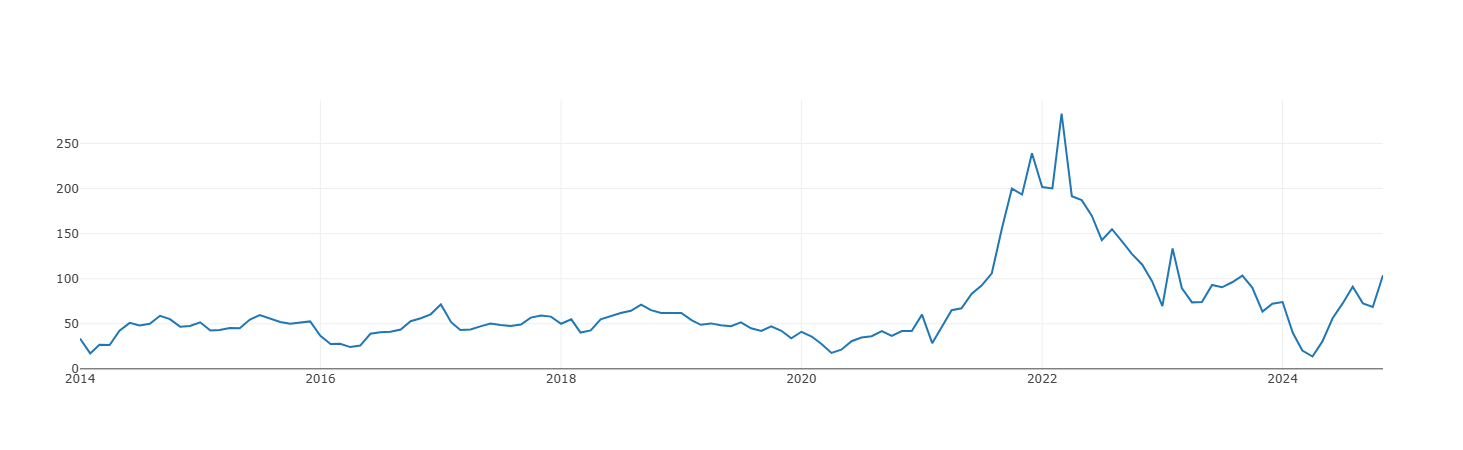

collect at cmd5.sc:12

defined function analisisPrecioMensual

In [6]:
def analisisPrecioMensual (df: DataFrame): Unit = {
    //Calculamos la generacion total por año
    val evolucionPrecio = df
      .select($"FechaDia", $"PrecioMercado_€")
      .groupBy(date_format(col("FechaDia"), "yyyy-MM").as("FechaMes"))
      .agg(avg("PrecioMercado_€").as("Media_mensual_€"))
      .orderBy($"FechaMes")
    
    
    //Pintamos la gráfica
    val fechas = evolucionPrecio.select("FechaMes").as[String].collect.toSeq
    val precioMensual = evolucionPrecio.select("Media_mensual_€").as[Double].collect.toSeq
    val evolucionMercadosMensualmente = Scatter(fechas, precioMensual, name = "Precio Mercados en €")

    val data = Seq(evolucionMercadosMensualmente)
    
    plot(data)
    
}
analisisPrecioMensual(datosConsulta2)

collect at cmd3.sc:17

1 / 1

collect at cmd3.sc:17

200 / 200

collect at cmd3.sc:17

200 / 200

collect at cmd3.sc:17

11 / 11

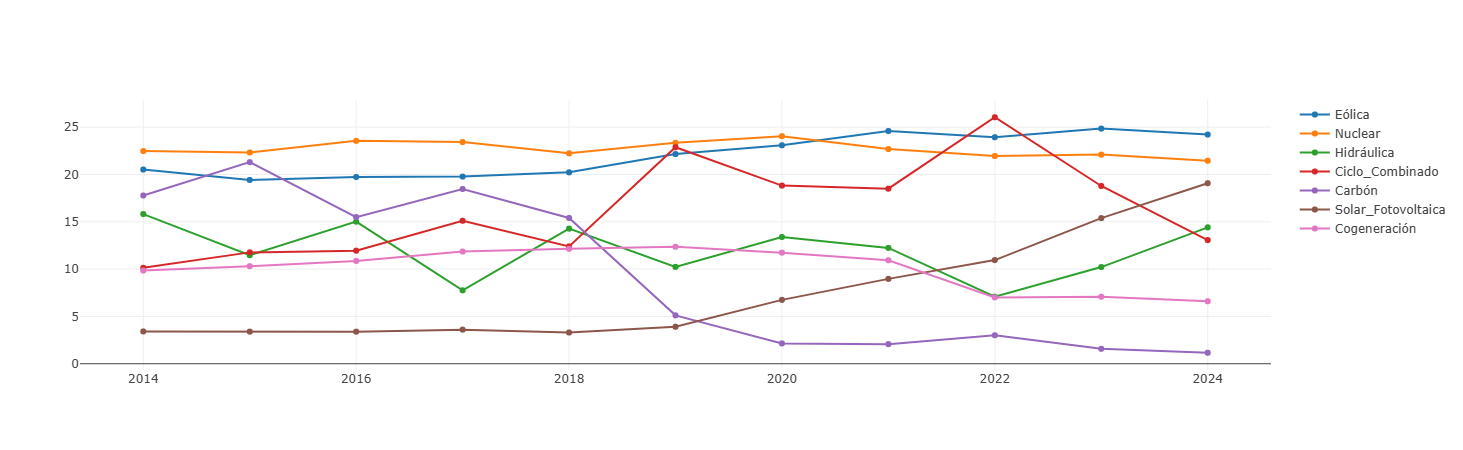

defined function graficarEvolucionPorcentajesAnuales

In [4]:
def graficarEvolucionPorcentajesAnuales(df: DataFrame): Unit = {
    // Calcular el promedio anual por tipo de energía
    val dfAnual = df
        .groupBy(date_format(col("FechaDia"), "yyyy").as("FechaAnio")) // Agrupar por año
        .agg(
            avg("Eólica_%").as("Promedio_Eólica"),
            avg("Nuclear_%").as("Promedio_Nuclear"),
            avg("Hidráulica_%").as("Promedio_Hidráulica"),
            avg("Ciclo_combinado_%").as("Promedio_Ciclo_Combinado"),
            avg("Carbón_%").as("Promedio_Carbón"),
            avg("Solar_fotovoltaica_%").as("Promedio_Solar_Fotovoltaica"),
            avg("Cogeneración_%").as("Promedio_Cogeneración")
        )
        .orderBy("FechaAnio")

    // Realizar un único `collect` para traer todos los datos al driver
    val datosAnuales = dfAnual.collect()

    // Extraer los años (FechaAnio)
    val anios = datosAnuales.map(row => row.getAs[String]("FechaAnio")).toSeq // Convertir a Seq

    // Filtrar dinámicamente las columnas de tipo de energía
    val energiaColumnas = dfAnual.columns.filter(_.startsWith("Promedio_")) // Filtrar columnas de energías

    // Crear una serie para cada tipo de energía
    val series = energiaColumnas.map { tipo =>
        val valores = datosAnuales.map(row => row.getAs[Double](tipo)).toSeq // Convertir a Seq
        Scatter(anios, valores, name = tipo.replace("Promedio_", "")) // Crear serie eliminando el prefijo
    }.toSeq // Asegurar que `series` sea un `Seq`

    // Graficar todas las series juntas
    plot(series)
}

// Llamar a la función con el DataFrame filtrado
graficarEvolucionPorcentajesAnuales(datosConsulta2)


In [12]:
def calcularCorrelaciones(df: DataFrame, precioColumna: String): DataFrame = {
    // Filtrar columnas relevantes (las que terminan con "_%" o "_MWh")
    val columnasEnergia = df.columns.filter(col => col.endsWith("_%") || col.endsWith("_MWh"))

    // Calcular correlación para cada columna de energía
    val correlaciones = columnasEnergia.map { colEnergia =>
        val correlacion = df.stat.corr(precioColumna, colEnergia) // Calcular correlación
        (colEnergia, correlacion) // Devolver columna y correlación
    }

    // Convertir a DataFrame para ordenarlo y mostrarlo
    import spark.implicits._
    correlaciones.toSeq.toDF("Energía", "Correlación").orderBy(desc("Correlación"))
}

// Llamar a la función para calcular las correlaciones
val resultadoCorrelaciones = calcularCorrelaciones(datosConsulta2, "PrecioMercado_€")
resultadoCorrelaciones.show()


corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

corr at cmd11.sc:7

1 / 1

show at cmd11.sc:18

14 / 14

+--------------------+--------------------+
|             Energía|         Correlación|
+--------------------+--------------------+
| Ciclo_combinado_MWh|  0.5112746442572531|
|   Ciclo_combinado_%| 0.49218935745748954|
|Solar_fotovoltaic...|  0.2924628212691979|
|Solar_fotovoltaica_%|  0.2629925493953789|
|         Nuclear_MWh|0.027181711226881945|
|          Eólica_MWh|-0.08305614302342378|
|           Nuclear_%|-0.09493220327086346|
|    Cogeneración_MWh|-0.12271759590501925|
|            Eólica_%|-0.12568609916427367|
|          Carbón_MWh|-0.18132259474230716|
|      Cogeneración_%|-0.18327962958232394|
|            Carbón_%| -0.1946874392238486|
|      Hidráulica_MWh| -0.2891542535476879|
|        Hidráulica_%|-0.32012965511957897|
+--------------------+--------------------+



defined function calcularCorrelaciones
resultadoCorrelaciones: DataFrame = [Energía: string, Correlación: double]

cmd12.sc:1: not found: value dfBalance
val res12 = dfBalance.show()
            ^Compilation Failed

: 